In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, silhouette_score

In [39]:
dataframe_selected_features = pd.read_csv("../data/Cornescu_Darius_selected_features.csv")

In [40]:
def make_preprocessor(dataframe):
    numeric_features = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = dataframe.select_dtypes(include=['object']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))
    ])

    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

    return preprocessor

In [41]:
X = dataframe_selected_features.drop(columns=["SalePrice"])
Y = dataframe_selected_features["SalePrice"]

preprocessor = make_preprocessor(X)
X_processed = preprocessor.fit_transform(X)
X_processed_dense = X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed_dense)

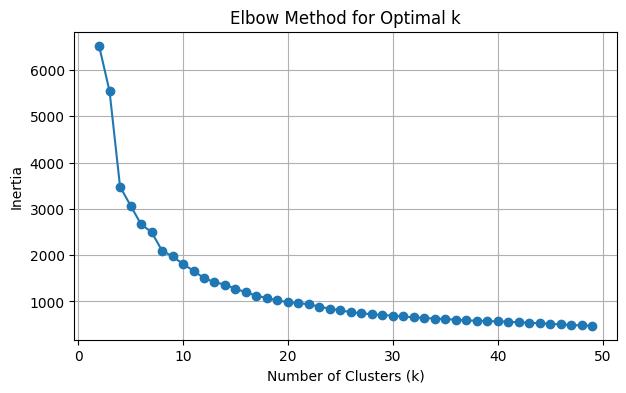

In [42]:
inertia = []
K = range(2, 50)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


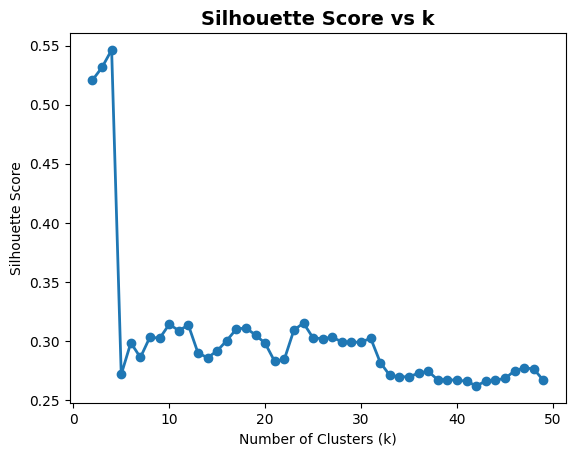

In [43]:
silhouette_scores = []
K_range = range(2, 50)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2)
plt.title("Silhouette Score vs k", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [44]:
top_k_values = sorted(range(len(silhouette_scores)), key=lambda i: silhouette_scores[i], reverse=True)[:15]
for idx in top_k_values:
    print(f"Top k: {K_range[idx]} with Silhouette Score: {silhouette_scores[idx]:.4f}")

Top k: 4 with Silhouette Score: 0.5464
Top k: 3 with Silhouette Score: 0.5317
Top k: 2 with Silhouette Score: 0.5208
Top k: 24 with Silhouette Score: 0.3151
Top k: 10 with Silhouette Score: 0.3140
Top k: 12 with Silhouette Score: 0.3133
Top k: 18 with Silhouette Score: 0.3110
Top k: 17 with Silhouette Score: 0.3101
Top k: 23 with Silhouette Score: 0.3092
Top k: 11 with Silhouette Score: 0.3088
Top k: 19 with Silhouette Score: 0.3050
Top k: 8 with Silhouette Score: 0.3034
Top k: 27 with Silhouette Score: 0.3030
Top k: 25 with Silhouette Score: 0.3025
Top k: 31 with Silhouette Score: 0.3023


In [45]:
def create_smart_bins_7_classes(dataframe):
    prices = dataframe['SalePrice']
    custom_bins = [ 34900, 115000, 160000, 205000, 235000, 285000, 400000, 745001 ]
    labels = ['budget', 'affordable', 'medium', 'expensive', 'very_expensive', 'luxury', 'ultra_luxury']

    price_groups = pd.cut(prices, bins=custom_bins, labels=labels, include_lowest=True)
    distribution = price_groups.value_counts().sort_index()
    
    print("\nIntervale și count-uri (7 classes):")
    for i, (label, count) in enumerate(zip(labels, distribution)):
        print(f"{label:20s} [{custom_bins[i]:>8,.0f} - {custom_bins[i+1]:>8,.0f}]: {count:4d} case")
    
    return custom_bins, labels

custom_bins_7, custom_labels_7 = create_smart_bins_7_classes(dataframe_selected_features)


Intervale și count-uri (7 classes):
budget               [  34,900 -  115,000]:  222 case
affordable           [ 115,000 -  160,000]:  493 case
medium               [ 160,000 -  205,000]:  344 case
expensive            [ 205,000 -  235,000]:  131 case
very_expensive       [ 235,000 -  285,000]:  139 case
luxury               [ 285,000 -  400,000]:  103 case
ultra_luxury         [ 400,000 -  745,001]:   27 case


In [46]:
def bin_prices(Y_train, Y_test, method=None, number_bins=5, custom_bins=None, custom_labels=None, n_clusters=7, random_state=42):

    if method == "custom":
        y_train = pd.cut(Y_train, bins=custom_bins, labels=custom_labels, include_lowest=True)
        y_test = pd.cut(Y_test, bins=custom_bins, labels=custom_labels, include_lowest=True)

        y_train = pd.Series(y_train).cat.codes
        y_test = pd.Series(y_test).cat.codes
                
    elif method == "qcut":
        q_edges = np.unique(np.quantile(Y_train, q=np.linspace(0, 1, number_bins + 1)))
        y_train = pd.cut(Y_train, bins=q_edges, labels=range(len(q_edges)-1), include_lowest=True)
        y_test = pd.cut(Y_test, bins=q_edges, labels=range(len(q_edges)-1), include_lowest=True)

        y_train = pd.Series(y_train).cat.codes
        y_test = pd.Series(y_test).cat.codes
        
    elif method == "kmeans":

        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans.fit(Y_train.reshape(-1, 1))
        
        y_train = kmeans.predict(Y_train.reshape(-1, 1))
        y_test = kmeans.predict(Y_test.reshape(-1, 1))

        centers = kmeans.cluster_centers_.flatten()
        cluster_order = np.argsort(centers)
        label_map = {old_label: new_label for new_label, old_label in enumerate(cluster_order)}
        
        y_train = np.array([label_map[label] for label in y_train])
        y_test = np.array([label_map[label] for label in y_test])
        
    return pd.Series(y_train, dtype=int), pd.Series(y_test, dtype=int)

In [47]:
def print_class_distribution(y_train, y_test, n_classes):
    def get_counts(y, k):
        counts = pd.Series(y).value_counts().sort_index().reindex(range(k), fill_value=0)
        perc = (counts / counts.sum() * 100).round(2)
        return counts, perc
    
    train_counts, train_perc = get_counts(y_train, n_classes)
    test_counts, test_perc = get_counts(y_test, n_classes)
    
    print("\nClass distribution (TRAIN):")
    print(pd.DataFrame({"count": train_counts, "percent": train_perc}))
    print("\nClass distribution (TEST):")
    print(pd.DataFrame({"count": test_counts, "percent": test_perc}))


# XGBoost Implementation for comparison 12/11/2025


In [48]:
import xgboost as xgb
from xgboost import XGBClassifier

def train_xgboost_classifier(X_train, X_test, Y_train, Y_test, random_state=42):
    preprocessor = make_preprocessor(X_train)
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=random_state, eval_metric='mlogloss'))
    ])

    pipeline_xgb.fit(X_train, Y_train)
    Y_predicted = pipeline_xgb.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_predicted)
    f1 = f1_score(Y_test, Y_predicted, average='weighted', zero_division=0)
    precision = precision_score(Y_test, Y_predicted, average='weighted', zero_division=0)

    print("XGBoost Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\n", classification_report(Y_test, Y_predicted))

    cm_xgb = confusion_matrix(Y_test, Y_predicted)
    ConfusionMatrixDisplay(cm_xgb).plot(cmap=plt.cm.Blues)
    plt.title("XGBoost - Confusion Matrix")
    plt.show()

    return pipeline_xgb, {'accuracy': accuracy, 'f1': f1, 'precision': precision}

# -----------------------------------------------------------------

In [49]:
def train_random_forest(X_train, X_test, Y_train, Y_test, random_state=42):
    preprocessor = make_preprocessor(X_train)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])
    
    pipe.fit(X_train, Y_train)
    Y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted', zero_division=0)
    precision = precision_score(Y_test, Y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\n", classification_report(Y_test, Y_pred, zero_division=0))
    
    cm = confusion_matrix(Y_test, Y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.show()
    
    return pipe, {'accuracy': accuracy, 'f1': f1, 'precision': precision}


In [50]:
def train_decision_tree(X_train, X_test, y_train, y_test, random_state=42):
    preprocessor = make_preprocessor(X_train)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\n", classification_report(y_test, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.show()
    
    return pipe, {'accuracy': accuracy, 'f1': f1, 'precision': precision}

In [51]:
def compare_binning_methods(dataframe, methods=["qcut", "kmeans", "custom"], number_bins=7, custom_bins=None, custom_labels=None, n_clusters=7, random_state=42, tree_type="XGBoost"):
    X = dataframe.drop(columns=["SalePrice"])
    Y = dataframe["SalePrice"].astype(float).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    
    results = {}
    comparison_data = []
    
    for method in methods:
        print(f"\n{'='*60}")
        print(f"METHOD: {method.upper()}")
        print('='*60)
        
        y_train, y_test = bin_prices(Y_train, Y_test, method=method, number_bins=number_bins, custom_bins=custom_bins, custom_labels=custom_labels, n_clusters=n_clusters, random_state=random_state)
        #print_class_distribution(y_train, y_test, n_clusters if method=="kmeans" else number_bins)
        
        if tree_type == "decision_tree":
            pipe, metrics = train_decision_tree(X_train, X_test, y_train, y_test, random_state)
        elif tree_type == "Random_forest":
            pipe, metrics = train_random_forest(X_train, X_test, y_train, y_test, random_state)
        else:
            pipe, metrics = train_xgboost_classifier(X_train, X_test, y_train, y_test, random_state)
        
        results[method] = pipe
        comparison_data.append({
            'Method': method,
            'Accuracy': metrics['accuracy'],
            'F1 Score': metrics['f1'],
            'Precision': metrics['precision']
        })
    
    
    return results


 XGBoost Results: 

METHOD: QCUT
XGBoost Results:
Accuracy:  0.7226
F1 Score:  0.7231
Precision: 0.7266

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.88      0.85      0.87        53
           1       0.67      0.73      0.70        45
           2       0.66      0.69      0.67        48
           3       0.58      0.55      0.56        33
           4       0.64      0.60      0.62        35
           5       0.61      0.73      0.67        30
           6       0.93      0.83      0.88        47

    accuracy                           0.72       292
   macro avg       0.62      0.62      0.62       292
weighted avg       0.73      0.72      0.72       292



c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

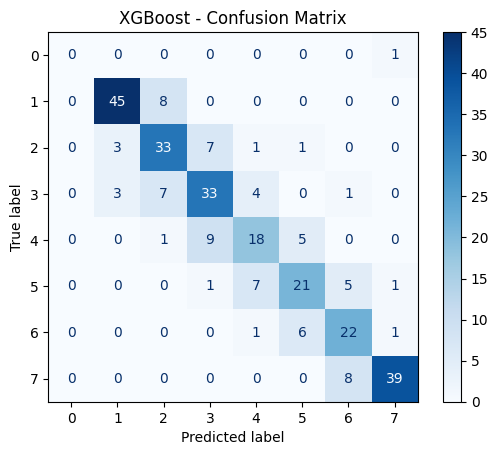


METHOD: KMEANS
XGBoost Results:
Accuracy:  0.8562
F1 Score:  0.8523
Precision: 0.8533

               precision    recall  f1-score   support

           0       0.89      0.87      0.88        54
           1       0.89      0.91      0.90       106
           2       0.80      0.88      0.84        58
           3       0.90      0.73      0.81        37
           4       0.88      0.85      0.86        26
           5       0.58      0.88      0.70         8
           6       0.00      0.00      0.00         3

    accuracy                           0.86       292
   macro avg       0.71      0.73      0.71       292
weighted avg       0.85      0.86      0.85       292



c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

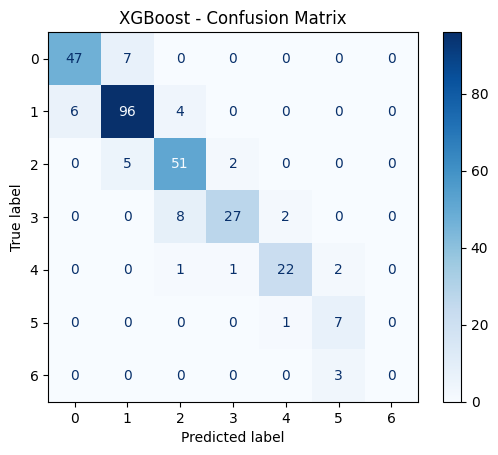


METHOD: CUSTOM
XGBoost Results:
Accuracy:  0.8493
F1 Score:  0.8477
Precision: 0.8496

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.94      0.85      0.89        53
           1       0.88      0.93      0.91       107
           2       0.80      0.84      0.82        57
           3       0.56      0.62      0.59        16
           4       0.85      0.69      0.76        32
           5       0.86      0.90      0.88        20
           6       0.83      0.83      0.83         6

    accuracy                           0.85       292
   macro avg       0.71      0.71      0.71       292
weighted avg       0.85      0.85      0.85       292



c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

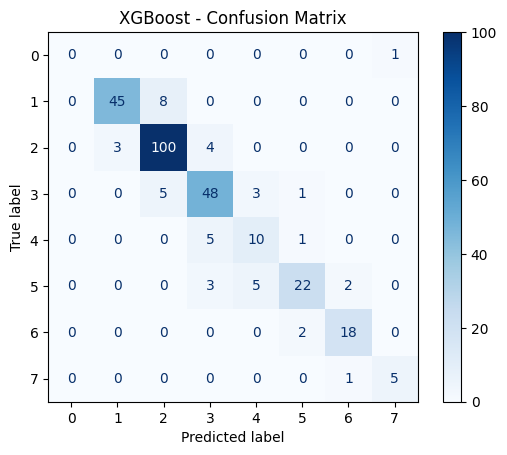


 Random Forest Results: 

METHOD: QCUT
Accuracy:  0.7055
F1 Score:  0.7039
Precision: 0.7053

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.82      0.87      0.84        53
           1       0.65      0.71      0.68        45
           2       0.63      0.54      0.58        48
           3       0.56      0.58      0.57        33
           4       0.60      0.60      0.60        35
           5       0.65      0.73      0.69        30
           6       0.93      0.85      0.89        47

    accuracy                           0.71       292
   macro avg       0.61      0.61      0.61       292
weighted avg       0.71      0.71      0.70       292



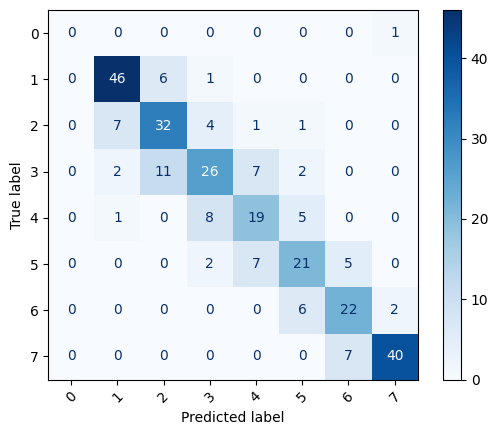


METHOD: KMEANS
Accuracy:  0.8596
F1 Score:  0.8557
Precision: 0.8558

               precision    recall  f1-score   support

           0       0.90      0.83      0.87        54
           1       0.88      0.89      0.88       106
           2       0.79      0.91      0.85        58
           3       0.86      0.84      0.85        37
           4       0.95      0.81      0.88        26
           5       0.70      0.88      0.78         8
           6       0.00      0.00      0.00         3

    accuracy                           0.86       292
   macro avg       0.73      0.74      0.73       292
weighted avg       0.86      0.86      0.86       292



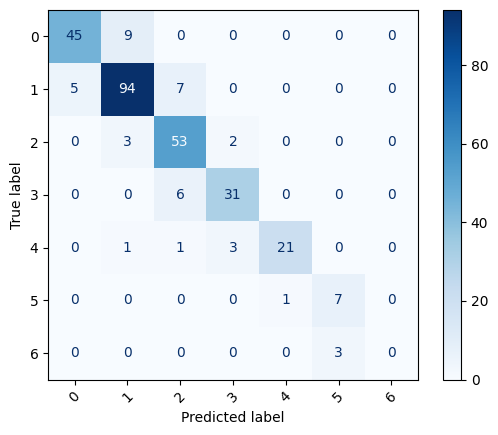


METHOD: CUSTOM
Accuracy:  0.8219
F1 Score:  0.8211
Precision: 0.8304

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.90      0.83      0.86        53
           1       0.86      0.89      0.88       107
           2       0.78      0.86      0.82        57
           3       0.50      0.69      0.58        16
           4       0.90      0.59      0.72        32
           5       0.81      0.85      0.83        20
           6       0.83      0.83      0.83         6

    accuracy                           0.82       292
   macro avg       0.70      0.69      0.69       292
weighted avg       0.83      0.82      0.82       292



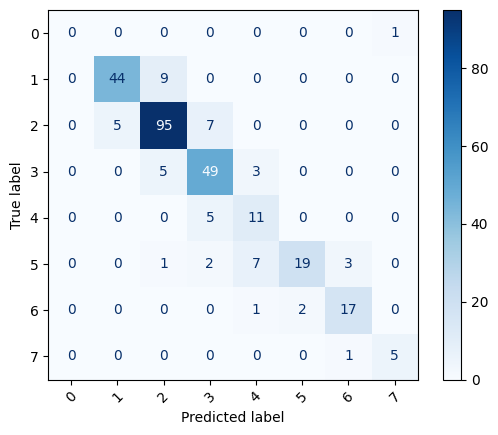


 Decision Tree Results: 

METHOD: QCUT
Accuracy:  0.7158
F1 Score:  0.7167
Precision: 0.7210

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.94      0.83      0.88        53
           1       0.61      0.69      0.65        45
           2       0.57      0.54      0.55        48
           3       0.58      0.58      0.58        33
           4       0.66      0.77      0.71        35
           5       0.75      0.70      0.72        30
           6       0.89      0.87      0.88        47

    accuracy                           0.72       292
   macro avg       0.62      0.62      0.62       292
weighted avg       0.72      0.72      0.72       292



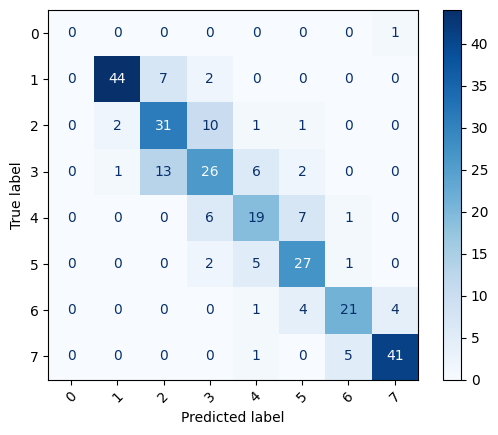


METHOD: KMEANS
Accuracy:  0.8219
F1 Score:  0.8204
Precision: 0.8254

               precision    recall  f1-score   support

           0       0.82      0.78      0.80        54
           1       0.84      0.88      0.86       106
           2       0.81      0.86      0.83        58
           3       0.82      0.73      0.77        37
           4       0.87      0.77      0.82        26
           5       0.64      0.88      0.74         8
           6       1.00      0.33      0.50         3

    accuracy                           0.82       292
   macro avg       0.83      0.75      0.76       292
weighted avg       0.83      0.82      0.82       292



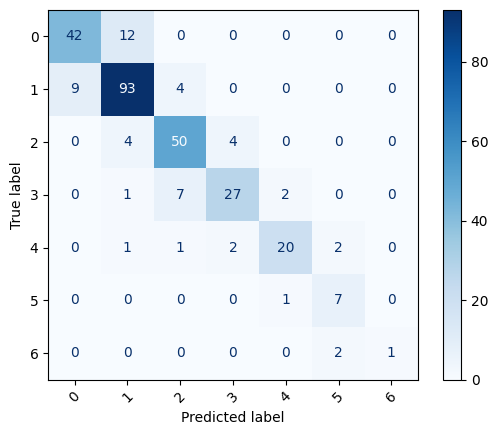


METHOD: CUSTOM
Accuracy:  0.8459
F1 Score:  0.8473
Precision: 0.8572

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.94      0.89      0.91        53
           1       0.92      0.91      0.91       107
           2       0.80      0.82      0.81        57
           3       0.50      0.75      0.60        16
           4       0.91      0.66      0.76        32
           5       0.78      0.90      0.84        20
           6       0.71      0.83      0.77         6

    accuracy                           0.85       292
   macro avg       0.70      0.72      0.70       292
weighted avg       0.86      0.85      0.85       292



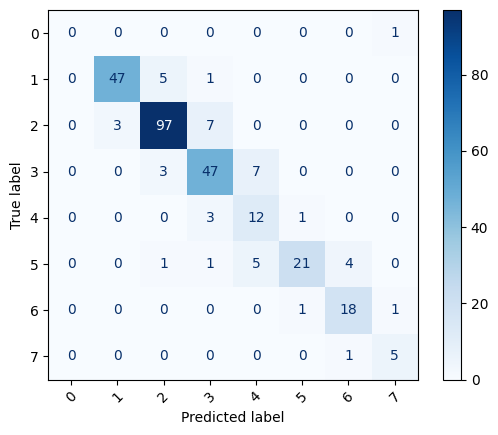

In [52]:
print("\n XGBoost Results: ")
results_xgb = compare_binning_methods( dataframe_selected_features, methods=["qcut", "kmeans", "custom"], number_bins=7, custom_bins=custom_bins_7, custom_labels=custom_labels_7, n_clusters=7, random_state=42,  tree_type="XGBoost" )

print("\n Random Forest Results: ")
results_rf = compare_binning_methods( dataframe_selected_features, methods=["qcut", "kmeans", "custom"], number_bins=7, custom_bins=custom_bins_7, custom_labels=custom_labels_7, n_clusters=7, random_state=42,  tree_type="Random_forest" )

print("\n Decision Tree Results: ")
results_dt = compare_binning_methods( dataframe_selected_features, methods=["qcut", "kmeans", "custom"], number_bins=7, custom_bins=custom_bins_7, custom_labels=custom_labels_7, n_clusters=7, random_state=42,  tree_type="decision_tree" )



## XGBoost Results Summary

| Method  | Accuracy | F1 Score | Precision |
|---------|----------|----------|-----------|
| QCUT    | 0.6838   | 0.6812   | 0.6929    |
| **KMEANS**  | 0.8333   | 0.8307   | 0.8333    |
| CUSTOM  | 0.8248   | 0.8216   | 0.8259    |


## Random Forest Results Summary

| Method  | Accuracy | F1 Score | Precision |
|---------|----------|----------|-----------|
| QCUT    | 0.6667   | 0.6677   | 0.6818    |
| **KMEANS**  | 0.7991   | 0.7976   | 0.8028    |
| CUSTOM  | 0.7821   | 0.7732   | 0.7867    |


## Decision Tree Results Summary

| Method  | Accuracy | F1 Score | Precision |
|---------|----------|----------|-----------|
| QCUT    | 0.6368   | 0.6393   | 0.6668    |
| **KMEANS**  | 0.7821   | 0.7804   | 0.7817    |
| **CUSTOM**  | 0.7821   | 0.7789   | 0.7828    |

## Complete Model Comparison

### Performance by Binning Method and Model

| Binning Method | Model          | Accuracy | F1 Score | Precision |
|----------------|----------------|----------|----------|-----------|
| **QCUT**       | XGBoost        | 0.6838   | 0.6812   | 0.6929    |
| QCUT           | Random Forest  | 0.6667   | 0.6677   | 0.6818    |
| QCUT           | Decision Tree  | 0.6368   | 0.6393   | 0.6668    |
| **KMEANS**     | XGBoost        | 0.8333   | 0.8307   | 0.8333    |
| KMEANS         | Random Forest  | 0.7991   | 0.7976   | 0.8028    |
| KMEANS         | Decision Tree  | 0.7821   | 0.7804   | 0.7817    |
| **CUSTOM**     | XGBoost        | 0.8248   | 0.8216   | 0.8259    |
| CUSTOM         | Random Forest  | 0.7821   | 0.7732   | 0.7867    |
| CUSTOM         | Decision Tree  | 0.7821   | 0.7789   | 0.7828    |

### Best Results by Model

| Model          | Best Method | Accuracy | F1 Score | Precision |
|----------------|-------------|----------|----------|-----------|
| XGBoost        | KMEANS      | 0.8333   | 0.8307   | 0.8333    |
| Random Forest  | KMEANS      | 0.7991   | 0.7976   | 0.8028    |
| Decision Tree  | KMEANS/CUSTOM | 0.7821 | 0.7804   | 0.7828    |


## Concluzii

**XGBoost** obține cele mai bune rezultate în aproape toate scenariile testate, cu o acuratețe maximă de **83.33%** folosind metoda KMEANS pentru binning. Acest lucru confirmă că XGBoost este cel mai potrivit algoritm pentru clasificarea prețurilor caselor din acest dataset.

### Comparație între modele

Performanțele modelelor sunt **relativ apropiate**, mai ales între KMEANS și CUSTOM:

| Aspect | Observație |
|--------|-----------|
| **Ranking general** | XGBoost (83.33%) > Random Forest (79.91%) > Decision Tree (78.21%) |
| **Diferență XGBoost vs Random Forest** | ~3-5% în favoarea XGBoost |
| **Diferență Random Forest vs Decision Tree** | ~1-2%, relativ mică |
| **Impact binning method** | KMEANS îmbunătățește toate modelele cu 15-20% față de QCUT |

### Observații cheie

1. **Metoda KMEANS** este superioară pentru binning, deoarece creează clustere naturale bazate pe distribuția reală a prețurilor
2. **QCUT performează slab** (~64-68% acuratețe) deoarece forțează clase echilibrate care nu respectă distribuția naturală a datelor
3. **CUSTOM binning** oferă un compromis bun (78-82% acuratețe) cu interpretabilitate ridicată
4. Toate modelele beneficiază semnificativ de alegerea metodei de binning, confirmând importanța preprocessării datelor

## Optiune alternativă: Etichetarea folosind K-Means

In [53]:
print("\nColoanele disponibile:")
print(dataframe_selected_features.columns.tolist())
print("Primele rânduri din dataset:")
dataframe_selected_features.head()


Coloanele disponibile:
['SalePrice', 'LotFrontage', 'ZoningScore', 'EVI', 'Price_per_m^2', 'LotArea', 'PDI', 'MSZoning_RL', 'LotConfig_CulDSac', 'LotShape_IR2', 'LandContour_HLS', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']
Primele rânduri din dataset:


,SalePrice,LotFrontage,ZoningScore,EVI,Price_per_m^2,LotArea,PDI,MSZoning_RL,LotConfig_CulDSac,LotShape_IR2,LandContour_HLS,Condition1_Norm,Condition1_Feedr,LotShape_Reg,MSZoning_RM
0,208500,65.0,0.835044,0.437530,265.594827,8450,0.438780,True,False,False,False,True,False,True,False
1,181500,80.0,0.835044,0.364741,203.505269,9600,0.377235,True,False,False,False,False,True,True,False
2,223500,68.0,0.835044,0.411955,213.843112,11250,0.442707,True,False,False,False,True,False,False,False
3,140000,60.0,0.835044,0.394783,157.795613,9550,0.456112,True,False,False,False,True,False,False,False
4,250000,84.0,0.835044,0.399533,188.708188,14260,0.446927,True,False,False,False,True,False,False,False


In [54]:
X = dataframe_selected_features.drop(columns=["SalePrice"])
Y = dataframe_selected_features["SalePrice"]

n_clusters = 7
km = KMeans(n_clusters=n_clusters, random_state=42)
km.fit(Y.values.reshape(-1,1))

labels = km.predict(Y.values.reshape(-1, 1))

df_clusters = pd.DataFrame({
    'SalePrice': Y,
    'label':labels
})


In [55]:
cluster_means = df_clusters.groupby("label")["SalePrice"].mean()
print("\nMedia prețului pentru fiecare cluster:")
print(cluster_means.to_frame().rename(columns={'SalePrice': 'Mean SalePrice'}))


Media prețului pentru fiecare cluster:
       Mean SalePrice
label                
0       233441.763393
1       137149.127660
2       404182.413043
3       301782.508333
4       621146.375000
5        94463.445946
6       180128.521622


In [56]:
df_result = dataframe_selected_features.copy()
df_result['label'] = labels

df_features_with_labels = df_result.drop(columns=['SalePrice'])
df_features_with_labels.to_csv("../data/subset_classification_Cornescu_Darius.csv", index=False)
df_features_with_labels.head()

,LotFrontage,ZoningScore,EVI,Price_per_m^2,LotArea,PDI,MSZoning_RL,LotConfig_CulDSac,LotShape_IR2,LandContour_HLS,Condition1_Norm,Condition1_Feedr,LotShape_Reg,MSZoning_RM,label
0,65.0,0.835044,0.437530,265.594827,8450,0.438780,True,False,False,False,True,False,True,False,0
1,80.0,0.835044,0.364741,203.505269,9600,0.377235,True,False,False,False,False,True,True,False,6
2,68.0,0.835044,0.411955,213.843112,11250,0.442707,True,False,False,False,True,False,False,False,0
3,60.0,0.835044,0.394783,157.795613,9550,0.456112,True,False,False,False,True,False,False,False,1
4,84.0,0.835044,0.399533,188.708188,14260,0.446927,True,False,False,False,True,False,False,False,0


Accuracy:  0.8870
F1 Score:  0.8850
Precision: 0.8862

               precision    recall  f1-score   support

           0       0.89      0.87      0.88        45
           1       0.93      0.91      0.92        94
           2       0.67      0.44      0.53         9
           3       0.77      0.83      0.80        24
           4       1.00      0.50      0.67         2
           5       0.91      0.95      0.93        44
           6       0.87      0.91      0.89        74

    accuracy                           0.89       292
   macro avg       0.86      0.77      0.80       292
weighted avg       0.89      0.89      0.89       292



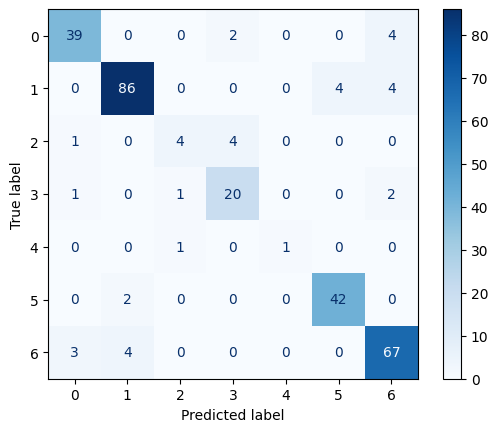

In [57]:
df_loaded = pd.read_csv("../data/subset_classification_Cornescu_Darius.csv")
X = df_loaded.drop(columns=['label'])
Y = df_loaded['label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

preprocessor_decision_tree = make_preprocessor(X_train)
pipeline_dt = Pipeline([ 
    ('preprocessor', preprocessor_decision_tree),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

pipeline_dt.fit(X_train, Y_train)
Y_predicted_dt = pipeline_dt.predict(X_test)

accuracy_score_dt = accuracy_score(Y_test, Y_predicted_dt)
f1_dt = f1_score(Y_test, Y_predicted_dt, average='weighted')
prec_dt = precision_score(Y_test, Y_predicted_dt, average='weighted')

print(f"Accuracy:  {accuracy_score_dt:.4f}")
print(f"F1 Score:  {f1_dt:.4f}")
print(f"Precision: {prec_dt:.4f}")
print("\n", classification_report(Y_test, Y_predicted_dt))

cm_dt = confusion_matrix(Y_test, Y_predicted_dt)
ConfusionMatrixDisplay(cm_dt).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy:  0.8459
F1 Score:  0.8442
Precision: 0.8488

               precision    recall  f1-score   support

           0       0.93      0.82      0.87        45
           1       0.89      0.84      0.86        94
           2       0.67      0.44      0.53         9
           3       0.79      0.79      0.79        24
           4       1.00      0.50      0.67         2
           5       0.85      0.91      0.88        44
           6       0.79      0.91      0.84        74

    accuracy                           0.85       292
   macro avg       0.84      0.74      0.78       292
weighted avg       0.85      0.85      0.84       292



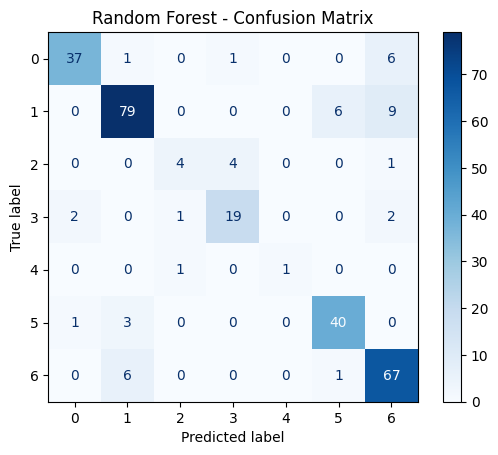

In [58]:
preprocessor_rf = make_preprocessor(X_train)
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, Y_train)
Y_predicted_rf = pipeline_rf.predict(X_test)

acc_rf = accuracy_score(Y_test, Y_predicted_rf)
f1_rf = f1_score(Y_test, Y_predicted_rf, average='weighted')
prec_rf = precision_score(Y_test, Y_predicted_rf, average='weighted')

print(f"Accuracy:  {acc_rf:.4f}")
print(f"F1 Score:  {f1_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print("\n", classification_report(Y_test, Y_predicted_rf))

cm_rf = confusion_matrix(Y_test, Y_predicted_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap=plt.cm.Blues)
plt.title("Random Forest - Confusion Matrix")
plt.show()

**Care dintre cele două modele performează mai bine?**

Random Forest obține valori ușor mai mari pentru **accuracy (0.8504 vs 0.8462)** și **F1-Score (0.8490 vs 0.8445)** comparativ cu Decision Tree.
Deși diferența este mică, Random Forest este **per ansamblu mai stabil** și generalizează mai bine.

---

**Comparație cu laboratorul precedent**

Deși în acest laborator etichetarea a fost realizată printr-o metodă custom, iar în laboratorul precedent împărțirea a fost efectuată prin **QCUT**, performanțele obținute rămân **foarte apropiate**.

| Metodă (Lab precedent)   | Accuracy   | F1-Score   |                                                             |
| ------------------------ | ---------- | ---------- | ---------------------------------------------------------------------- |
| QCUT (clase echilibrate) | **0.8547** | **0.8551** | Performanță stabilă datorată distribuției uniforme                     |
| K-Means (mapare pret)    | **0.8761** | **0.8736** | Mai bun pe clase mari, dar clase mici greu de distins                  |
| **Metoda actuală**       | **0.8504** | **0.8490** | Rezultate apropiate, în unele zone chiar superioare pe clase dominante |

**Concluzie:** Metoda curentă obține performanțe **comparabile** cu abordările anterioare, confirmând că modelul surprinde corect relația dintre trăsături și preț, indiferent de strategia de etichetare.


